In [1]:
!pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report, hamming_loss
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
import mlflow
import dagshub

dagshub.init(repo_owner='Shrijeet14', repo_name='toxic-comment-classification', mlflow=True)


mlflow.set_tracking_uri("https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=f5eade6f-fe2d-46c8-98b3-d2b0f1e0ecd8&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=ee7c34f44f3512aeb6f1954cbf8a42d7882dbdcaad65043a9d324326dbd0ce8d




Accessing as Shrijeet14

Initialized MLflow to track repo "Shrijeet14/toxic-comment-classification"

Repository Shrijeet14/toxic-comment-classification initialized!

In [9]:
df = pd.read_csv('processed_data.csv')

In [12]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category,word_count
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,24
1,aww ! match background colour seemingly stuck ...,0,0,0,0,0,0,0,11
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0,21
3,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0,54
4,sir hero chance remember page ?,0,0,0,0,0,0,0,6


In [10]:
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category,word_count
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,24
1,aww ! match background colour seemingly stuck ...,0,0,0,0,0,0,0,11
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0,21
3,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0,54
4,sir hero chance remember page ?,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...
220673,jerome see never got around ! surprised looked...,0,0,0,0,0,0,0,49
220674,lucky bastard url heh famous kida envy congrats,0,0,0,0,0,0,0,8
220675,shame ! ! ! want speak gay romanian,0,0,0,0,0,0,0,8
220676,mel gibson nazi bitch make shity movie ha much...,1,0,1,0,1,0,-1,15


In [11]:
df.isna().sum()

,0
comment_text,2
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0
category,0
word_count,0


In [17]:
df = df[~df['comment_text'].isnull()]

In [20]:
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
from tqdm import tqdm

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
device = "/GPU:0" if tf.config.experimental.list_physical_devices('GPU') else "/CPU:0"
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
tqdm.pandas(desc="Processing Embeddings")

with tf.device(device):
    df['vector'] = df['comment_text'].progress_apply(lambda x: embed([x]).numpy()[0])

print(df.head())

Num GPUs Available: 1


Processing Embeddings: 100%|██████████| 220676/220676 [22:08<00:00, 166.05it/s]

                                        comment_text  toxic  severe_toxic  \
0  explanation edits made username hardcore metal...      0             0   
1  aww ! match background colour seemingly stuck ...      0             0   
2  hey man really trying edit war guy constantly ...      0             0   
3  make real suggestion improvement wondered sect...      0             0   
4                    sir hero chance remember page ?      0             0   

   obscene  threat  insult  identity_hate  category  word_count  \
0        0       0       0              0         0          24   
1        0       0       0              0         0          11   
2        0       0       0              0         0          21   
3        0       0       0              0         0          54   
4        0       0       0              0         0           6   

                                              vector  
0  [-0.040181033, -0.05182516, 0.04892755, 0.0251...  
1  [-0.01590716, -0.0103


<ipython-input-20-2c3c4cc3ccaa>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vector'] = df['comment_text'].progress_apply(lambda x: embed([x]).numpy()[0])


In [21]:
df.to_csv('embeddings_data_gpu.csv')

Num GPUs Available: 1
GPU memory config error: Physical devices cannot be modified after being initialized


2025/03/29 22:54:46 INFO mlflow.tracking.fluent: Experiment with name 'XG-Boost- USE Encoded Embeddings' does not exist. Creating a new experiment.
Training Models:   0%|          | 0/8 [00:00<?, ?it/s]

Training model 1/8 with params: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:55:06] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:55:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:55:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:55:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0.

🏃 View run auspicious-hen-508 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7/runs/ae8c78fe198b49a599392f5a41638ce4
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7
Training model 2/8 with params: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:57:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:57:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:57:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:57:22] WARNING: /workspac

🏃 View run resilient-bear-362 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7/runs/4738fe00f01f43c5a0b5bb154be029d0
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7
Training model 3/8 with params: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 6, 'estimator__n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:59:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:59:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:59:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:59:24] WARNING: /workspac

🏃 View run rebellious-kit-109 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7/runs/c3445a44c1c847dea718109eeae19e75
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7
Training model 4/8 with params: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 6, 'estimator__n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:01:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:01:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:01:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:01:31] WARNING: /workspac

🏃 View run respected-cow-248 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7/runs/980fbf9e0030479a8001baa2f5376176
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7
Training model 5/8 with params: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:03:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:03:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:03:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:03:45] WARNING: /workspac

🏃 View run stylish-newt-669 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7/runs/eb2ce26d6d6d48338323992ec249614b
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7
Training model 6/8 with params: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:05:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:05:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:05:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:05:42] WARNING: /workspac

🏃 View run resilient-kite-733 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7/runs/f352535c51274563adc485cf48a74888
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7
Training model 7/8 with params: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 6, 'estimator__n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:07:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:07:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:07:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:07:43] WARNING: /workspac

🏃 View run charming-dolphin-250 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7/runs/8197b4a0709c4dcfa147932e8d7b5cca
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7
Training model 8/8 with params: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 6, 'estimator__n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:09:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:09:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:09:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:09:48] WARNING: /workspac

🏃 View run youthful-goose-437 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7/runs/e47eb75949ee45a5a5e1e422bbd4dc18
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7
Running GridSearchCV for best model...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:11:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:11:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:11:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:11:54] WARNING: /workspa

🏃 View run bright-perch-290 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7/runs/281f1610abbc41f0bf6618a3d1fc998c
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/7


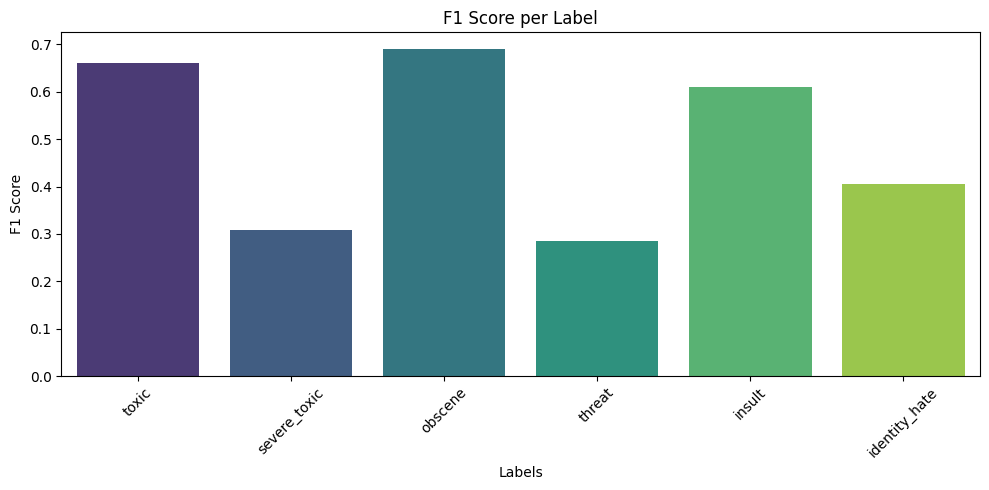

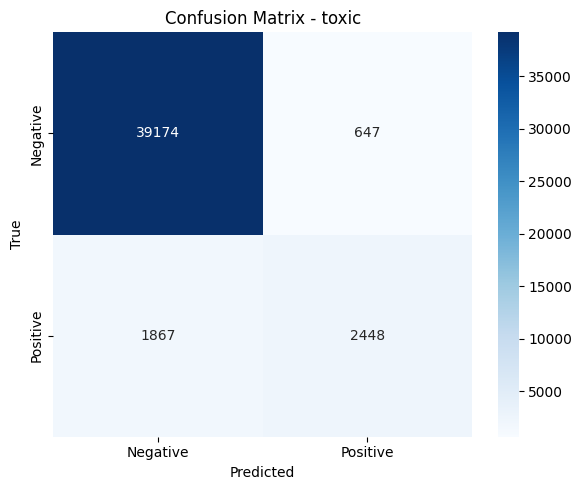

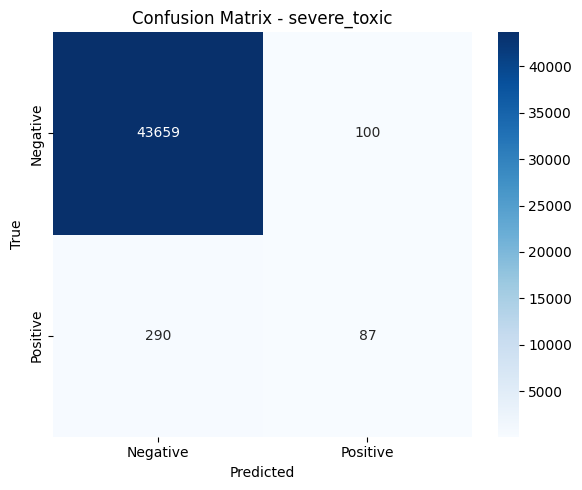

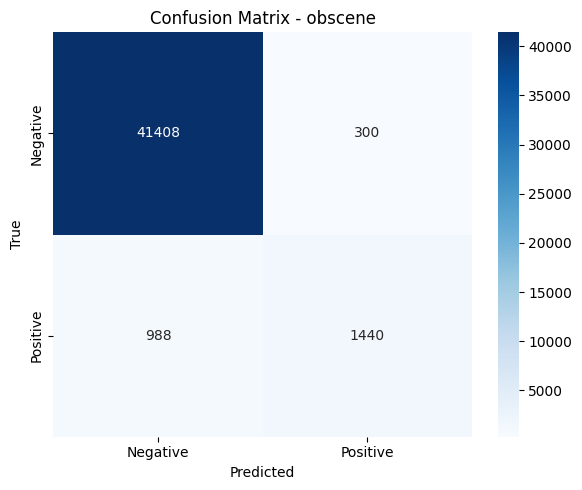

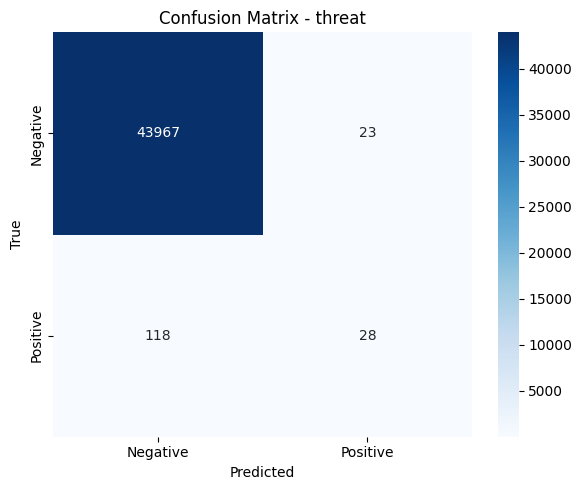

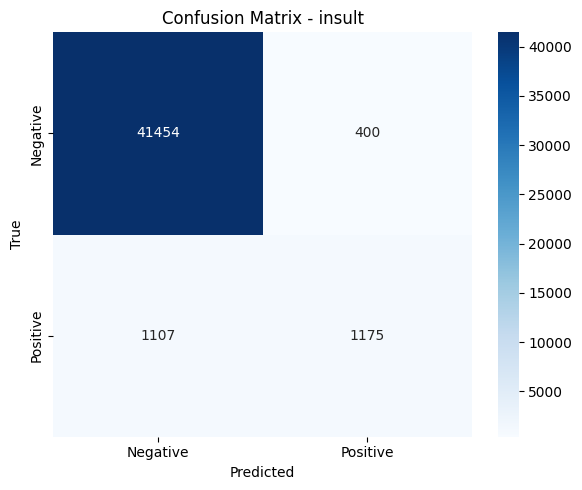

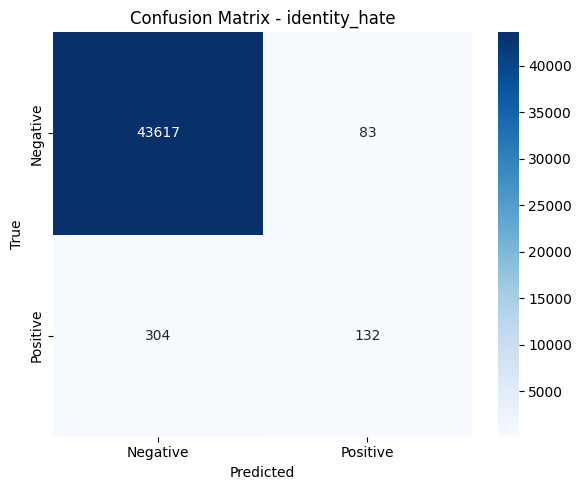

In [22]:
import mlflow.sklearn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, hamming_loss, confusion_matrix
from tqdm import tqdm
import gc

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU memory config error: {e}")

mlflow.set_experiment("XG-Boost- USE Encoded Embeddings")

X = np.stack(df['vector'].to_numpy())
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gpu_params = {
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'predictor': 'gpu_predictor'
}

param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [3, 6],
    'estimator__learning_rate': [0.01, 0.1]
}

with mlflow.start_run():
    param_list = list(ParameterGrid(param_grid))

    for i, params in enumerate(tqdm(param_list, desc="Training Models")):
        print(f"Training model {i+1}/{len(param_list)} with params: {params}")

        with mlflow.start_run(nested=True):
            xgb_base = XGBClassifier(
                objective='binary:logistic',
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42,
                n_jobs=1,
                **gpu_params
            )

            model = MultiOutputClassifier(xgb_base)
            model.set_params(**params)

            X_train_main, X_val, y_train_main, y_val = train_test_split(
                X_train, y_train, test_size=0.1, random_state=42
            )

            eval_set = [(X_val, y_val.iloc[:, 0])]
            model.fit(X_train_main, y_train_main)

            y_pred = model.predict(X_test)
            y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
            hl = hamming_loss(y_test_array, y_pred)
            report = classification_report(y_test_array, y_pred,
                                         target_names=y.columns,
                                         output_dict=True)

            mlflow.log_params(params)
            mlflow.log_metric("hamming_loss", hl)
            for label in y.columns:
                mlflow.log_metric(f"f1_{label}", report[label]["f1-score"])

            del model, y_pred, report
            gc.collect()
            tf.keras.backend.clear_session()

    print("Running GridSearchCV for best model...")
    xgb = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=1,
        **gpu_params
    )

    multi_xgb = MultiOutputClassifier(xgb)
    clf = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='f1_macro', n_jobs=1)

    best_model = clf.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
    best_hl = hamming_loss(y_test_array, y_pred)
    best_report = classification_report(y_test_array, y_pred,
                                      target_names=y.columns,
                                      output_dict=True)

    mlflow.log_params(best_model.best_params_)
    mlflow.log_metric("best_hamming_loss", best_hl)
    mlflow.sklearn.log_model(best_model, "xgboost_model")

    f1_scores = [best_report[label]["f1-score"] for label in y.columns]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=y.columns, y=f1_scores, palette="viridis")
    plt.xlabel("Labels")
    plt.ylabel("F1 Score")
    plt.title("F1 Score per Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("f1_scores.png")
    mlflow.log_artifact("f1_scores.png")

    for i, label in enumerate(y.columns):
        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y_test_array[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {label}')
        plt.tight_layout()
        cm_filename = f"confusion_matrix_{label}.png"
        plt.savefig(cm_filename)
        mlflow.log_artifact(cm_filename)


    del best_model, y_pred, best_report
    gc.collect()
    tf.keras.backend.clear_session()

    mlflow.end_run()

Experiment-2 : Using BiLSTM

In [26]:
import tensorflow as tf
import mlflow.tensorflow

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU memory config error: {e}")

mlflow.set_experiment("BiLSTM-Toxic-Comment-Classification")

X = np.stack(df['vector'].to_numpy())
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

input_dim = X_train.shape[1]

class TqdmProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(TqdmProgressCallback, self).__init__()
        self.epochs = epochs
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.epochs, desc="Training BiLSTM")

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        metrics_str = " - ".join([f"{k}: {v:.4f}" for k, v in logs.items()])
        self.pbar.set_postfix_str(metrics_str)

    def on_train_end(self, logs=None):
        self.pbar.close()

hyperparameters = [
    {"lstm_units": 128, "dropout": 0.3, "learning_rate": 0.001},
    {"lstm_units": 256, "dropout": 0.5, "learning_rate": 0.0005}
]

with mlflow.start_run(run_name="BiLSTM-Grid-Search"):
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(hyperparameters):
        print(f"Training BiLSTM model {i+1}/{len(hyperparameters)} with params: {params}")

        with mlflow.start_run(run_name=f"BiLSTM-Run-{i+1}", nested=True):
            tf.keras.backend.clear_session()

            mlflow.log_params(params)  # Logging hyperparameters

            model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(input_dim,)),
                tf.keras.layers.Reshape((1, input_dim)),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(params["lstm_units"], return_sequences=True)),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(params["lstm_units"])),
                tf.keras.layers.Dropout(params["dropout"]),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(params["dropout"]),
                tf.keras.layers.Dense(6, activation='sigmoid')
            ])

            optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
            model.compile(
                optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
            )

            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, restore_best_weights=True
            )
            tqdm_callback = TqdmProgressCallback(epochs=30)

            epochs = 100
            batch_size = 64

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping, tqdm_callback],
                verbose=0
            )

            val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)

            for epoch, metrics in enumerate(zip(history.history['loss'],
                                             history.history['accuracy'],
                                             history.history['auc'],
                                             history.history['val_loss'],
                                             history.history['val_accuracy'],
                                             history.history['val_auc'])):
                mlflow.log_metrics({
                    "loss": metrics[0],
                    "accuracy": metrics[1],
                    "auc": metrics[2],
                    "val_loss": metrics[3],
                    "val_accuracy": metrics[4],
                    "val_auc": metrics[5]
                }, step=epoch)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_params = params

            gc.collect()

    mlflow.log_params(best_params)  # Logging best hyperparameters
    print("Best BiLSTM model parameters:", best_params)

    y_pred_prob = best_model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    test_loss, test_acc, test_auc = best_model.evaluate(X_test, y_test, verbose=0)
    hl = hamming_loss(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)

    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_metric("hamming_loss", hl)

    for label in labels:
        mlflow.log_metric(f"f1_{label}", report[label]["f1-score"])

    mlflow.tensorflow.log_model(best_model, "bilstm_model")

    tf.keras.backend.clear_session()
    gc.collect()


Num GPUs Available: 1
GPU memory config error: Physical devices cannot be modified after being initialized
Training BiLSTM model 1/2 with params: {'lstm_units': 128, 'dropout': 0.3, 'learning_rate': 0.001}


Training BiLSTM:   0%|          | 0/30 [00:00<?, ?it/s]

🏃 View run BiLSTM-Run-1 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/8/runs/a2694a6adbc4426db859a91b2fa1f059
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/8
🏃 View run BiLSTM-Grid-Search at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/8/runs/1c3fef6d378e4d3496b2ae53d42ce302
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/8


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import mlflow.tensorflow

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU memory config error: {e}")

mlflow.set_experiment("BiLSTM-Toxic-Comment-Classification_new")

X = np.stack(df['vector'].to_numpy())
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

input_dim = X_train.shape[1]

class TqdmProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(TqdmProgressCallback, self).__init__()
        self.epochs = epochs
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.epochs, desc="Training BiLSTM")

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        metrics_str = " - ".join([f"{k}: {v:.4f}" for k, v in logs.items()])
        self.pbar.set_postfix_str(metrics_str)

    def on_train_end(self, logs=None):
        self.pbar.close()

hyperparameters = [
    {"lstm_units": 128, "dropout": 0.3, "learning_rate": 0.001},
    {"lstm_units": 256, "dropout": 0.5, "learning_rate": 0.0005}
]

with mlflow.start_run(run_name="BiLSTM-Grid-Search"):
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(hyperparameters):
        print(f"Training BiLSTM model {i+1}/{len(hyperparameters)} with params: {params}")

        with mlflow.start_run(run_name=f"BiLSTM-Run-{i+1}", nested=True):
            tf.keras.backend.clear_session()

            mlflow.log_params(params)  # Logging hyperparameters

            model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(input_dim,)),
                tf.keras.layers.Reshape((1, input_dim)),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(params["lstm_units"], return_sequences=True)),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(params["lstm_units"])),
                tf.keras.layers.Dropout(params["dropout"]),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(params["dropout"]),
                tf.keras.layers.Dense(6, activation='sigmoid')
            ])

            optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
            model.compile(
                optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
            )

            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, restore_best_weights=True
            )
            tqdm_callback = TqdmProgressCallback(epochs=30)

            epochs = 100
            batch_size = 64

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping, tqdm_callback],
                verbose=0
            )

            val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)

            for epoch, metrics in enumerate(zip(history.history['loss'],
                                             history.history['accuracy'],
                                             history.history['auc'],
                                             history.history['val_loss'],
                                             history.history['val_accuracy'],
                                             history.history['val_auc'])):
                mlflow.log_metrics({
                    "loss": metrics[0],
                    "accuracy": metrics[1],
                    "auc": metrics[2],
                    "val_loss": metrics[3],
                    "val_accuracy": metrics[4],
                    "val_auc": metrics[5]
                }, step=epoch)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_params = params

            gc.collect()

    mlflow.log_params(best_params)  # Logging best hyperparameters
    print("Best BiLSTM model parameters:", best_params)

    y_pred_prob = best_model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    test_loss, test_acc, test_auc = best_model.evaluate(X_test, y_test, verbose=0)
    hl = hamming_loss(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)

    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_metric("hamming_loss", hl)

    for label in labels:
        mlflow.log_metric(f"f1_{label}", report[label]["f1-score"])

    mlflow.tensorflow.log_model(best_model, "bilstm_model")

    tf.keras.backend.clear_session()
    gc.collect()


Num GPUs Available: 1
GPU memory config error: Physical devices cannot be modified after being initialized


2025/03/30 00:40:38 INFO mlflow.tracking.fluent: Experiment with name 'BiLSTM-Toxic-Comment-Classification_new' does not exist. Creating a new experiment.


Training BiLSTM model 1/2 with params: {'lstm_units': 128, 'dropout': 0.3, 'learning_rate': 0.001}


Training BiLSTM:   0%|          | 0/30 [35:39<?, ?it/s]

Training BiLSTM:  20%|██        | 6/30 [03:22<14:31, 36.32s/it, accuracy: 0.9728 - auc: 0.9776 - loss: 0.0556 - val_accuracy: 0.9846 - val_auc: 0.9732 - val_loss: 0.0584]

Experiment-2 : BiGRUs

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow.tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, confusion_matrix
from tqdm import tqdm
import gc

# Configure GPU
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU memory config error: {e}")

# Set up MLflow
mlflow.set_experiment("BiGRU-Toxic-Comment-Classification")

# Prepare data
X = np.stack(df['vector'].to_numpy())
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Input dimension (USE embedding size)
input_dim = X_train.shape[1]  # 512 for USE embeddings

# Define callback for tqdm progress bar
class TqdmProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(TqdmProgressCallback, self).__init__()
        self.epochs = epochs
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.epochs, desc="Training BiGRU")

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        metrics_str = " - ".join([f"{k}: {v:.4f}" for k, v in logs.items()])
        self.pbar.set_postfix_str(metrics_str)

    def on_train_end(self, logs=None):
        self.pbar.close()

# Memory management callback
class MemoryManagementCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

# Grid of hyperparameters to try
hyperparameters = [
    {"gru_units": 128, "dropout": 0.3, "learning_rate": 0.001},
    {"gru_units": 256, "dropout": 0.5, "learning_rate": 0.0005}
]

with mlflow.start_run(run_name="BiGRU-Grid-Search"):
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(hyperparameters):
        print(f"Training BiGRU model {i+1}/{len(hyperparameters)} with params: {params}")

        with mlflow.start_run(run_name=f"BiGRU-Run-{i+1}", nested=True):
            tf.keras.backend.clear_session()

            # Log parameters
            mlflow.log_params(params)

            # Build model
            model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(input_dim,)),
                tf.keras.layers.Reshape((1, input_dim)),  # Add sequence dimension
                tf.keras.layers.Bidirectional(tf.keras.layers.GRU(params["gru_units"], return_sequences=True)),
                tf.keras.layers.Bidirectional(tf.keras.layers.GRU(params["gru_units"])),
                tf.keras.layers.Dropout(params["dropout"]),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(params["dropout"]),
                tf.keras.layers.Dense(6, activation='sigmoid')
            ])

            # Compile model
            optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
            model.compile(
                optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
            )

            # Define callbacks
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, restore_best_weights=True
            )
            tqdm_callback = TqdmProgressCallback(epochs=30)
            memory_callback = MemoryManagementCallback()

            # Train model
            epochs = 100
            batch_size = 64

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping, tqdm_callback, memory_callback],
                verbose=0
            )

            # Evaluate on validation set
            val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)

            # Log metrics
            for epoch, metrics in enumerate(zip(history.history['loss'],
                                             history.history['accuracy'],
                                             history.history['auc'],
                                             history.history['val_loss'],
                                             history.history['val_accuracy'],
                                             history.history['val_auc'])):
                mlflow.log_metrics({
                    "loss": metrics[0],
                    "accuracy": metrics[1],
                    "auc": metrics[2],
                    "val_loss": metrics[3],
                    "val_accuracy": metrics[4],
                    "val_auc": metrics[5]
                }, step=epoch)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_params = params

            # Clean up
            gc.collect()

    print("Best BiGRU model parameters:", best_params)

    # Evaluate best model on test set
    y_pred_prob = best_model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    test_loss, test_acc, test_auc = best_model.evaluate(X_test, y_test, verbose=0)
    hl = hamming_loss(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)

    # Log final metrics
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_metric("hamming_loss", hl)

    for label in labels:
        mlflow.log_metric(f"f1_{label}", report[label]["f1-score"])

    # Save model
    mlflow.tensorflow.log_model(best_model, "bigru_model")

    # Create visualizations
    # 1. Training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.savefig("bigru_training_history.png")
    mlflow.log_artifact("bigru_training_history.png")

    # 2. F1 scores by label
    f1_scores = [report[label]["f1-score"] for label in labels]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels, y=f1_scores, palette="viridis")
    plt.xlabel("Labels")
    plt.ylabel("F1 Score")
    plt.title("F1 Score per Label - BiGRU Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("bigru_f1_scores.png")
    mlflow.log_artifact("bigru_f1_scores.png")

    # 3. Confusion matrices
    for i, label in enumerate(labels):
        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {label} (BiGRU)')
        plt.tight_layout()
        cm_filename = f"bigru_confusion_matrix_{label}.png"
        plt.savefig(cm_filename)
        mlflow.log_artifact(cm_filename)

    # Clean up
    tf.keras.backend.clear_session()
    gc.collect()